# Demonstration of the labfolio Factor Model

As an introduction, Stefan Jansen says the following in *Machine Learning for Trading (ML4T)*:

> There are several practical applications of factor models across the portfolio management process from construction and asset selection to risk management and performance evaluation. The importance of factor models continues to grow as common risk factors are now tradeable:
>
> - A summary of the returns of many assets by a much smaller number of factors reduces the amount of data required to estimate the covariance matrix when optimizing a portfolio
> - An estimate of the exposure of an asset or a portfolio to these factors allows for the management of the resultant risk, for instance by entering suitable hedges when risk factors are themselves traded
> - A factor model also permits the assessment of the incremental signal content of new alpha factors
> - A factor model can also help assess whether a manager's performance relative to a benchmark is indeed due to skill in selecting assets and timing the market, or if instead, the performance can be explained by portfolio tilts towards known return drivers that can today be replicated as low-cost, passively managed funds without incurring active management fees

We implement our factor model using Fama-Macbeth regression.

_____

In [1]:
# imports
import pandas as pd
from statsmodels.api import OLS, add_constant
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from linearmodels.asset_pricing import LinearFactorModel

/Users/MilesChild/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


*Data Retrieval*

Data for our portfolio and factor model is stored locally in two files:

- `portfolio.csv`: daily returns for our portfolio holdings
- `factors.csv`: daily returns for the factors in our factor model

In [2]:
portfolio_returns = pd.read_excel('portfolio_returns.xlsx', index_col='Unnamed: 0')
factor_returns = pd.read_excel('factor_returns.xlsx', index_col='Unnamed: 0')
portfolio_returns.index.name = 'date'
factor_returns.index.name = 'date'

def align_data(factor_df, asset_df):
    # Convert both DataFrames' indices to datetime if they aren't already
    factor_copy = factor_df.copy()
    asset_copy = asset_df.copy()
    factor_copy.index = pd.to_datetime(factor_copy.index)
    asset_copy.index = pd.to_datetime(asset_copy.index)
    
    # Find common dates between both DataFrames
    common_dates = factor_copy.index.intersection(asset_copy.index)
    
    # Reindex both DataFrames to use only the common dates
    factor_data = factor_copy.loc[common_dates]
    asset_data = asset_copy.loc[common_dates]

    # Delete intermediate dfs
    del factor_copy, asset_copy
    
    return factor_data, asset_data

factor_df, portfolio_df = align_data(factor_returns, portfolio_returns)

In [3]:
factor_df.head()

,ITOT,MTUM,QUAL,SIZE,USMV,VLUE
date,,,,,,
2023-01-04,0.008410,-0.000905,0.008096,0.016476,0.005542,0.015688
2023-01-05,-0.011864,-0.000697,-0.011610,-0.012481,-0.009232,-0.005077
2023-01-06,0.022824,0.016740,0.025700,0.023348,0.021697,0.025404
2023-01-09,0.000116,-0.013377,-0.000775,0.001287,-0.007215,-0.002541
2023-01-10,0.008135,0.005145,0.007238,0.008994,0.002880,0.007112


In [4]:
portfolio_df.head()

,AAPL,AMZN,BAC,CSCO,DIS,GOOGL,HD,INTC,JNJ,JPM,...,NFLX,NVDA,PEP,PFE,PG,TSLA,UNH,V,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2023-01-04,0.010314,-0.007924,0.018800,-0.008135,0.033832,-0.011670,0.012092,0.035541,0.010887,0.009325,...,0.049025,0.030318,-0.002452,-0.022044,0.004354,0.051249,-0.027264,0.025170,0.001114,0.002911
2023-01-05,-0.010605,-0.023726,-0.002050,-0.014090,-0.000652,-0.021344,-0.013324,-0.004335,-0.007384,-0.007552,...,0.000937,-0.032816,-0.010449,-0.009376,-0.012415,-0.029039,-0.028821,-0.007055,-0.003408,0.022374
2023-01-06,0.036794,0.035611,0.009979,0.030717,0.021758,0.013225,0.006530,0.042453,0.008110,0.019136,...,0.018889,0.041640,0.022586,0.025372,0.023813,0.024651,0.000082,0.031453,0.024499,0.012087
2023-01-09,0.004089,0.014870,-0.015112,0.005381,0.009050,0.007786,0.000882,0.020188,-0.025908,-0.004132,...,-0.001204,0.051753,-0.009774,-0.049686,-0.012214,0.059349,0.000122,0.003904,-0.012468,-0.018637
2023-01-10,0.004456,0.028732,0.006787,0.004734,0.008336,0.004544,0.008873,0.004435,-0.002392,0.008954,...,0.039249,0.017981,-0.008253,-0.015912,-0.000987,-0.007681,-0.008285,0.011391,-0.000621,0.014935


**Compute Excess Returns**

TODO

## Fama-Macbeth Regression

The Fama-Macbeth regression is a two-step regression which involves:
1. Estimating the **factor exposures** by regressing portfolio returns on the factor returns
2. Estimating the **factor risk premia** by regressing the portfolio returns on the factor exposures

In the first stage, we run N (number of assets or portfolios) time-series regressions of the factors as independent and asset returns as dependent variables. This allows us to estimate the factor exposures.

1. **First Stage - Factor Exposures (Time Series Regression)**
   For each asset/portfolio $i$, estimate factor betas over time $t$:
   
   $R_{it} = \alpha_i + \sum_{k=1}^K \beta_{ik}f_{kt} + \epsilon_{it}$
   
   where:
   - $R_{it}$ is the return of asset $i$ at time $t$
   - $\alpha_i$ is the intercept for asset $i$
   - $\beta_{ik}$ is the exposure of asset $i$ to factor $k$
   - $f_{kt}$ is the return of factor $k$ at time $t$
   - $\epsilon_{it}$ is the error term

In the second stage, we run T (number of time periods) cross-sectional regressions of the asset returns as dependent variables and the factor exposures as independent variables. This allows us to estimate the factor risk premia.

2. **Second Stage - Risk Premia (Cross-Sectional Regression)**
   For each time period $t$, estimate factor risk premia:
   
   $R_{it} = \lambda_{0t} + \sum_{k=1}^K \lambda_{kt}\hat{\beta}_{ik} + \eta_{it}$
   
   where:
   - $\lambda_{kt}$ is the risk premium for factor $k$ at time $t$
   - $\hat{\beta}_{ik}$ is the estimated factor exposure from stage 1
   - $\eta_{it}$ is the error term

The final factor risk premia are computed as the time-series averages:

$\hat{\lambda}_k = \frac{1}{T}\sum_{t=1}^T \hat{\lambda}_{kt}$

Given data on risk factors and portfolio returns, this methodology allows us to:
- Estimate portfolio exposures (betas) to risk factors
- Determine the market price of risk (risk premia) for each factor
- Calculate expected returns for any portfolio given its factor exposures

The risk premium then permits estimation of the expected return for any portfolio $p$:

$E[R_p] = \sum_{k=1}^K \hat{\lambda}_k\beta_{pk}$

where $\beta_{pk}$ is either known or can be estimated using the first-stage regression.

**Step 1 - Factor Exposures**

In [5]:
betas = []
for asset in portfolio_df.columns:
    step1 = OLS(endog=portfolio_df.loc[factor_df.index, asset], 
                exog=add_constant(factor_df)).fit()
    betas.append(step1.params.drop('const'))

betas = pd.DataFrame(betas, columns=factor_df.columns, index=portfolio_df.columns)
betas.head()

,ITOT,MTUM,QUAL,SIZE,USMV,VLUE
AAPL,2.830723,-0.278597,0.035225,-1.279840,-0.039806,-0.253666
AMZN,5.119998,-0.470386,-0.576678,-1.250014,-0.884926,-0.918133
BAC,1.103781,-0.034106,-1.389860,0.429970,-0.342191,1.300951
CSCO,-0.442711,-0.254709,0.938465,-0.946169,0.545354,1.166263
DIS,1.367204,-0.293871,-0.303131,-0.022186,-0.418651,0.535911


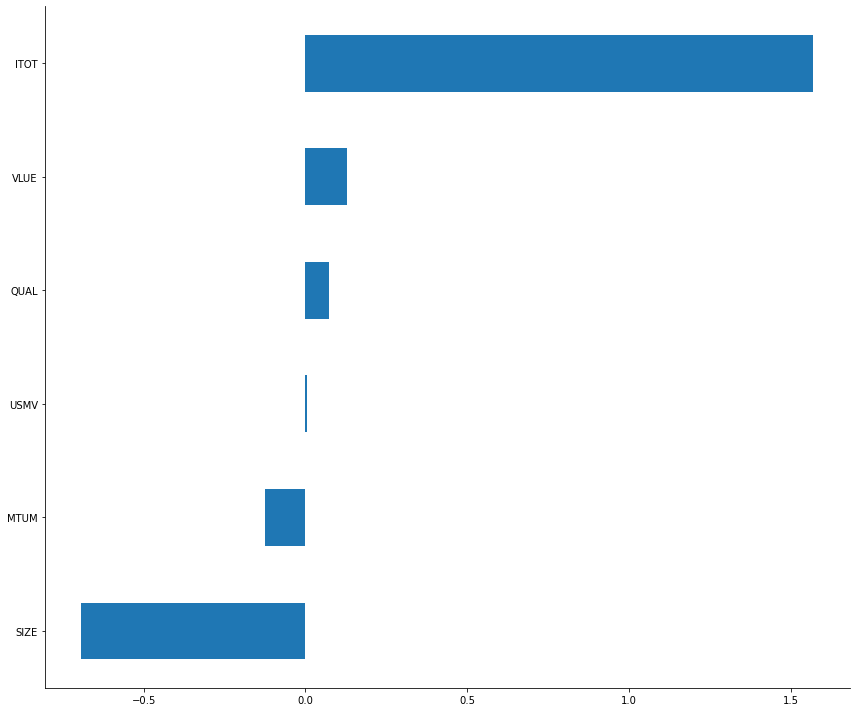

In [6]:
# Plot the portfolio beta values for each factor
betas.mean().sort_values().plot.barh(figsize=(12, 10))
sns.despine()
plt.tight_layout()

Portfolio Factor Exposures with Confidence Intervals:
      Portfolio_Beta  Beta_minus_1sd  Beta_plus_1sd
ITOT           1.569           1.440          1.697
MTUM          -0.124          -0.158         -0.090
QUAL           0.073          -0.011          0.158
SIZE          -0.693          -0.774         -0.611
USMV           0.006          -0.045          0.057
VLUE           0.130           0.075          0.184


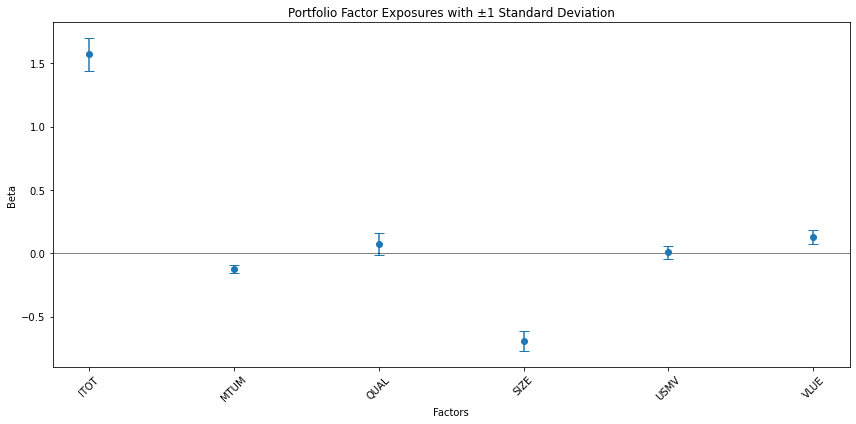

In [7]:
# Calculate portfolio betas and standard errors
n_assets = len(portfolio_returns.columns)
equal_weights = np.repeat(1/n_assets, n_assets)

# Get portfolio betas (weighted average of asset betas)
portfolio_betas = betas.T @ equal_weights

# Calculate standard errors for portfolio betas
# First get the covariance matrix of the beta estimates
beta_cov = np.zeros((len(betas.columns), len(betas.columns)))
for asset in portfolio_returns.columns:
    model = step1  # Assuming you stored OLS results in a dictionary
    beta_cov += (1/n_assets)**2 * model.cov_params().iloc[1:, 1:]  # Skip intercept

# Calculate standard errors
portfolio_beta_se = np.sqrt(np.diag(beta_cov))

# Create DataFrame with confidence intervals
beta_summary = pd.DataFrame({
    'Portfolio_Beta': portfolio_betas,
    'Beta_minus_1sd': portfolio_betas - portfolio_beta_se,
    'Beta_plus_1sd': portfolio_betas + portfolio_beta_se
})

# Round to 3 decimal places
beta_summary = beta_summary.round(3)

print("Portfolio Factor Exposures with Confidence Intervals:")
print(beta_summary)

# Optional: Create visualization
plt.figure(figsize=(12, 6))
plt.errorbar(x=beta_summary.index, 
            y=beta_summary['Portfolio_Beta'],
            yerr=portfolio_beta_se,
            fmt='o',
            capsize=5)
plt.title('Portfolio Factor Exposures with ±1 Standard Deviation')
plt.xlabel('Factors')
plt.ylabel('Beta')
plt.xticks(rotation=45)
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

**Step 2 - Risk Premia**

In [8]:
lambdas = []
# for each period, run a cross-sectional regression of the portfolio returns on the factor exposures
for period in portfolio_df.index:
    # run the regression
    step2 = OLS(
        endog=portfolio_df.loc[period, betas.index], # dependent variable: portfolio returns
        exog=betas # independent variables: factor exposures (calculated in step 1)
    ).fit()
    # append the coefficients to the list
    lambdas.append(step2.params)

In [9]:
lambdas = pd.DataFrame(lambdas, 
                       index=portfolio_df.index,
                       columns=betas.columns.tolist())
lambdas.head()

,ITOT,MTUM,QUAL,SIZE,USMV,VLUE
date,,,,,,
2023-01-04,0.018064,0.018924,0.015371,0.029976,0.004968,0.021401
2023-01-05,-0.010498,-0.005126,-0.011390,-0.008245,-0.010440,-0.001940
2023-01-06,0.023607,0.030188,0.026829,0.022218,0.020867,0.022393
2023-01-09,0.005314,0.011153,0.004392,0.007353,-0.008933,-0.004110
2023-01-10,0.007957,0.012396,0.010156,0.009250,0.002439,0.006146


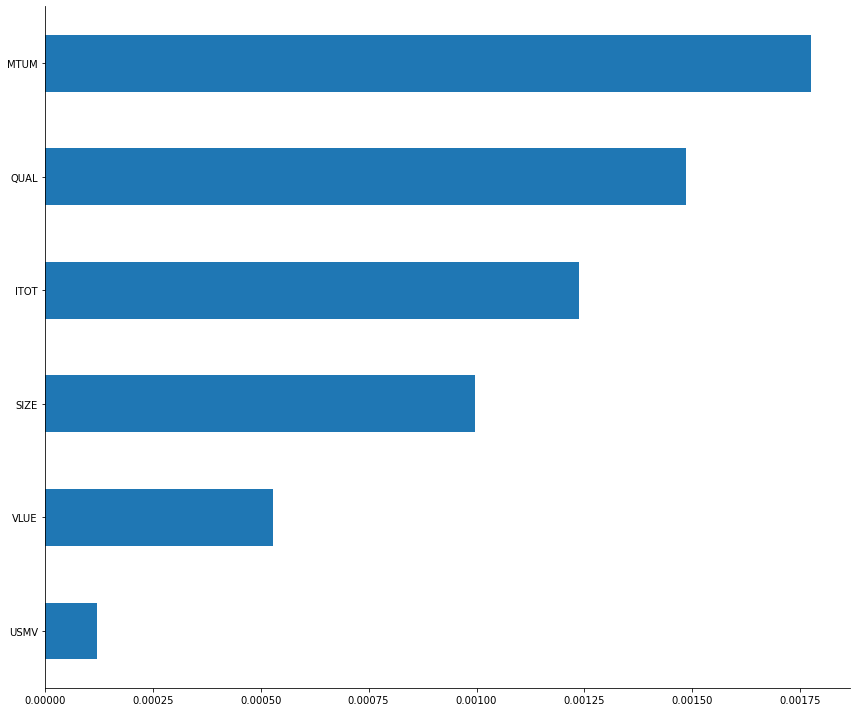

In [10]:
lambdas.mean().sort_values().plot.barh(figsize=(12, 10))
sns.despine()
plt.tight_layout()

**Summary of Lambdas (Risk Premia) Step**

*What does lambda mean in the context of the portfolio?*

Lambda (λ) represents the risk premium associated with each factor - essentially, how much extra return investors demand for being exposed to that factor's risk.

### Mathematical Context
In the Fama-MacBeth second stage regression:
$R_{it} = \lambda_{0t} + \sum_{k=1}^K \lambda_{kt}\hat{\beta}_{ik} + \eta_{it}$

Where:
- $\lambda_{kt}$ is the risk premium for factor k at time t
- $\lambda_0$ is the zero-beta rate (return of assets with zero factor exposure)
- $\hat{\beta}_{ik}$ is the exposure of asset i to factor k

### Practical Interpretation

1. **Positive λ**: 
   - Investors demand additional return for taking this factor risk
   - Example: If λ_value = 0.02 (2%), investors expect 2% additional annual return for each unit of value exposure

2. **Negative λ**:
   - Investors are willing to accept lower returns for exposure to this factor
   - Often indicates a "hedge factor" that provides protection in bad times

3. **Zero λ**:
   - Factor exposure is not compensated
   - Might indicate the factor isn't actually a priced risk

### Portfolio Applications
1. **Expected Return Calculation**:
   $E[R_p] = \lambda_0 + \sum_{k=1}^K \lambda_k\beta_{pk}$
   
2. **Risk-Return Trade-off Analysis**:
   - High λ + High β = High expected return but high risk
   - High λ + Low β = Lower expected return but lower risk

3. **Portfolio Optimization**:
   - Target factors with positive and significant λ
   - Consider avoiding factors with negative or insignificant λ

# Alternative Method: LinearFactorModel library

In [11]:
# Note: It is not a good idea to have more factors than assets
necessary_factors = ["ITOT", "VLUE", "SIZE", "MTUM", "QUAL", "USMV"]
factor_subset = factor_df.loc[:, necessary_factors]
factor_subset.head()

,ITOT,VLUE,SIZE,MTUM,QUAL,USMV
date,,,,,,
2023-01-04,0.008410,0.015688,0.016476,-0.000905,0.008096,0.005542
2023-01-05,-0.011864,-0.005077,-0.012481,-0.000697,-0.011610,-0.009232
2023-01-06,0.022824,0.025404,0.023348,0.016740,0.025700,0.021697
2023-01-09,0.000116,-0.002541,0.001287,-0.013377,-0.000775,-0.007215
2023-01-10,0.008135,0.007112,0.008994,0.005145,0.007238,0.002880


In [12]:
model = LinearFactorModel(portfolios=portfolio_df, 
                        factors=factor_subset)
res = model.fit()
model_rsq = res.rsquared
model_no_assets = len(res.params)
model_no_factors = len(factor_subset.columns)
print(f"R-squared: {model_rsq:.4f}")
print(f"Number of assets: {model_no_assets}")
print(f"Number of factors: {model_no_factors}")
print(res.summary)

R-squared: 0.4538
Number of assets: 24
Number of factors: 6
                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                 24   R-squared:                      0.4538
No. Factors:                          6   J-statistic:                    11.798
No. Observations:                   249   P-value                         0.8575
Date:                  Sat, Dec 07 2024   Distribution:                 chi2(18)
Time:                          17:43:21                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
ITOT           0.0012     0.0006     1.9041     0.0569 

In [13]:
# Show the model betas
res.params

,alpha,ITOT,VLUE,SIZE,MTUM,QUAL,USMV
AAPL,0.000166,2.830723,-0.253666,-1.279840,-0.278597,0.035225,-0.039806
AMZN,-0.000293,5.119998,-0.918133,-1.250014,-0.470386,-0.576678,-0.884926
BAC,-0.000152,1.103781,1.300951,0.429970,-0.034106,-1.389860,-0.342191
CSCO,0.000160,-0.442711,1.166263,-0.946169,-0.254709,0.938465,0.545354
DIS,-0.000733,1.367204,0.535911,-0.022186,-0.293871,-0.303131,-0.418651
GOOGL,-0.000699,3.853071,-0.666421,-1.638807,-0.601655,0.712839,-0.701941
HD,-0.000068,-1.133928,0.378218,0.895716,-0.369176,0.987697,0.253448
INTC,0.001187,1.185342,1.821820,-1.677576,-0.046964,0.713517,-0.752332
JNJ,0.000241,0.319709,0.324969,-0.778909,-0.151036,-0.270817,1.463635
JPM,0.000239,0.705295,0.551025,0.032522,0.204846,-0.524341,-0.073321
